# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.885650,False,-0.862677
1,-2.053192,False,-2.558602
2,1.780422,False,1.522954
3,0.236040,False,-0.086903
4,0.188621,False,-1.202499
...,...,...,...
995,1.336440,True,5.765693
996,1.723431,False,0.950712
997,1.946107,True,6.736787
998,1.409834,True,6.949373


<AxesSubplot: xlabel='v0'>

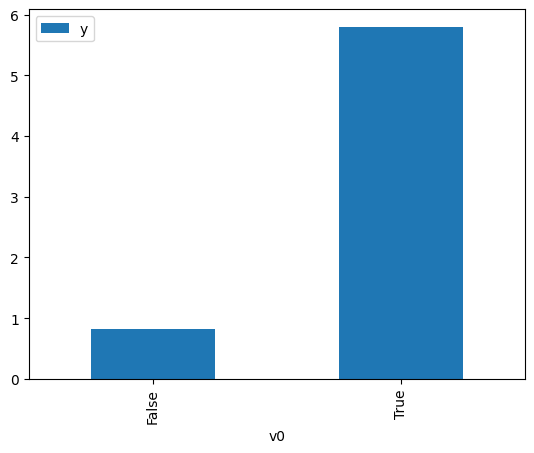

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

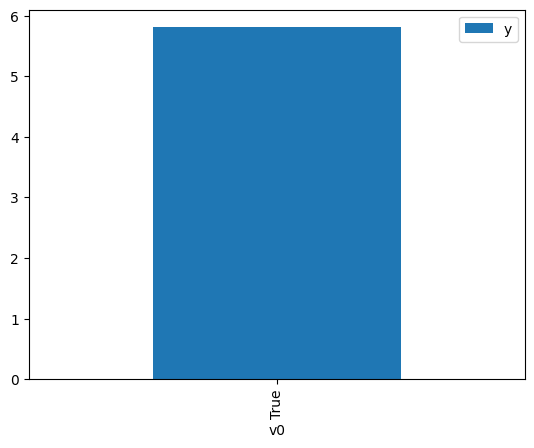

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.291465,False,0.246313,0.466247,2.144786
1,1.068485,False,0.382991,0.443501,2.254785
2,0.961019,False,0.358941,0.446635,2.238964
3,0.968751,False,0.576105,0.446410,2.240095
4,1.208301,False,3.586881,0.439431,2.275672
...,...,...,...,...,...
995,1.404710,False,-0.960797,0.433726,2.305601
996,0.961472,False,1.435399,0.446622,2.239030
997,2.516355,False,0.883720,0.401812,2.488726
998,0.325969,False,-0.474454,0.465233,2.149460


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.971338,True,3.875662,0.553666,1.806143
1,0.952406,True,5.415383,0.553113,1.807947
2,-0.215466,True,7.394763,0.518832,1.927407
3,2.460761,True,8.213264,0.596609,1.676139
4,1.619655,True,4.886169,0.572496,1.746736
...,...,...,...,...,...
995,2.467556,True,7.286871,0.596802,1.675597
996,0.319343,True,5.559038,0.534572,1.870655
997,1.432014,True,8.667309,0.567065,1.763465
998,-1.286155,True,4.842014,0.487238,2.052385


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                          1.047e+04
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:05:41   Log-Likelihood:                         -1415.4
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     998   BIC:                                      2845.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0393      0.028     37.302      0.000       0.985       1.094
x2             5.0443      0.049    102.900      0.000       4.948       5.141
==============================================================================
Omnibus:                        1.198   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.549   Jarque-Bera (JB):                1.266
Skew:                           0.057   Prob(JB):                        0.531
Kurtosis:                       2.868   Cond. No.                         2.23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""